In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

In [6]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


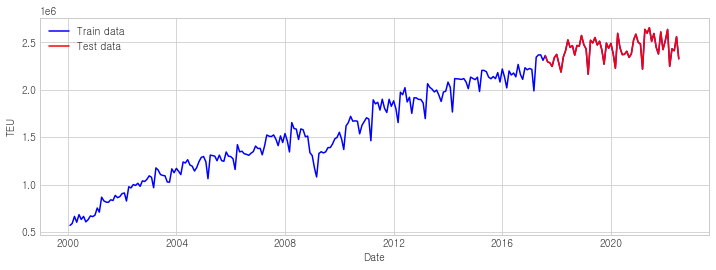

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [9]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [11]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [12]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [13]:
raw_df = data

In [14]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

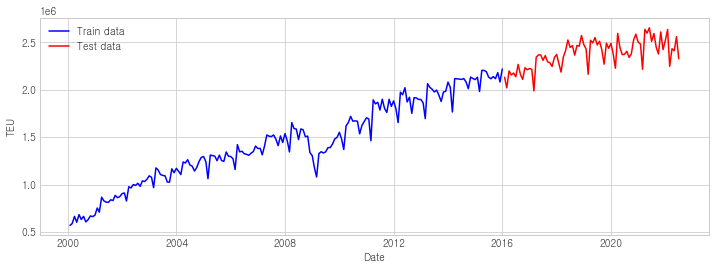

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [16]:
len(train),len(test)

(192, 78)

In [17]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [19]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [20]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 36   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [21]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [22]:
X_train.shape,Y_train.shape

((139, 18, 10), (139, 36, 1))

### 2. X_test,Y_test 배열

In [23]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [24]:
X_test.shape,Y_test.shape

((25, 18, 10), (25, 36, 1))

In [25]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [26]:
n_hidden = 64
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(Y_train.shape[1], Y_train.shape[2]))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='tanh',return_state = True, return_sequences=True)(input_train)

encoder_stack_h = MCDropout(0.8)(encoder_stack_h)
encoder_last_h = MCDropout(0.8)(encoder_last_h)
encoder_last_c = MCDropout(0.8)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = LSTM(n_hidden, activation = 'tanh',
                       return_state =False , 
                       return_sequences = True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

decoder_stack_h = MCDropout(0.8)(decoder_stack_h)

attention = dot([decoder_stack_h, encoder_stack_h], axes = [2,2])
attention = Activation('softmax')(attention)

context = dot([attention, encoder_stack_h], axes = [2,1])

decoder_combined_context = concatenate([context, decoder_stack_h])

out = TimeDistributed(Dense(8,activation='relu'))(decoder_combined_context)
out = TimeDistributed(Dense(1))(out)

model = Model(inputs=input_train, outputs = out)
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics = ['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 7s 294ms/step - loss: 0.2572 - mae: 0.4386 - val_loss: 0.0647 - val_mae: 0.2086
Epoch 2/200
14/14 [==============================] - 0s 33ms/step - loss: 0.0703 - mae: 0.2054 - val_loss: 0.1720 - val_mae: 0.3886
Epoch 3/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0495 - mae: 0.1723 - val_loss: 0.0682 - val_mae: 0.2283
Epoch 4/200
14/14 [==============================] - 0s 25ms/step - loss: 0.0346 - mae: 0.1474 - val_loss: 0.0675 - val_mae: 0.2251
Epoch 5/200
14/14 [==============================] - 0s 24ms/step - loss: 0.0260 - mae: 0.1276 - val_loss: 0.0444 - val_mae: 0.1750
Epoch 6/200
14/14 [==============================] - 0s 24ms/step - loss: 0.0203 - mae: 0.1119 - val_loss: 0.0312 - val_mae: 0.1433
Epoch 7/200
14/14 [==============================] - 0s 29ms/step - loss: 0.0179 - mae: 0.1047 - val_loss: 0.0392 - val_mae: 0.1622
Epoch 8/200
14/14 [==============================] - 0s 24ms/step - loss: 0

In [27]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

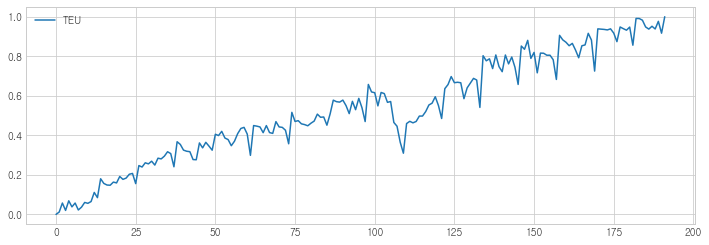

In [28]:
label_train.plot()

<AxesSubplot:>

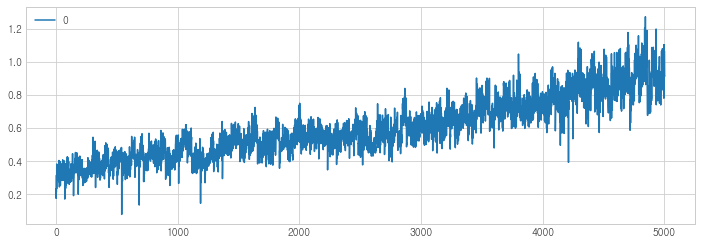

In [29]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### 1. 2017.07 ~ 2020.06

In [30]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [31]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [32]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

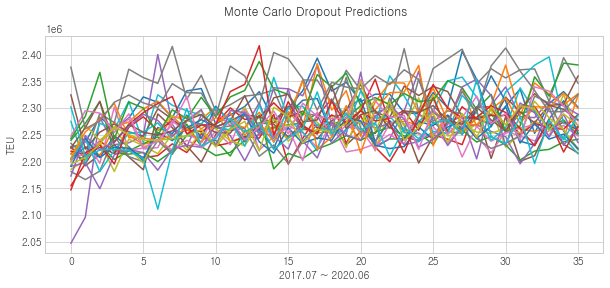

In [33]:
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2020.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [34]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [35]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [36]:
np.mean(df.std()/df.mean())

0.015778053551912308

In [37]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 134762.79516764497
MAPE: 5.398707618704141


In [38]:
mse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 134762.79516764497
MAPE: 5.62430828728368


In [39]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.head(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2225796.5,2225150.25,2214827.0,2154768.5,2046964.25,2228344.0,2199603.5,2234280.75,2185536.25,2275630.75,2203890.75,2214946.25,2239932.5,2219594.5,2191087.25,2325351.25,2206299.0,2181614.5,2201265.75,2204508.25,2191116.25,2205293.25,2243070.25,2146677.75,2172654.0,2225450.75,2247574.0,2377251.5,2195278.75,2302630.5


In [40]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 164510.89268894173
Mean MAPE: 5.909799113636165


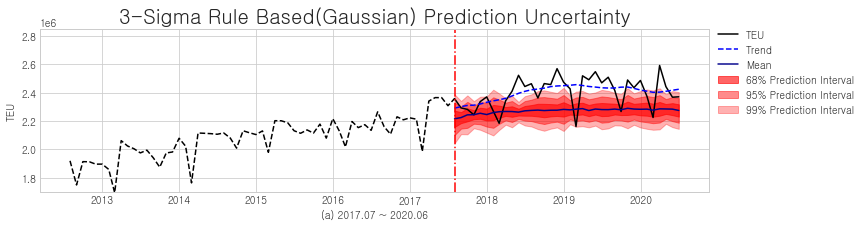

In [41]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().mean())/ test_data.head(36).reset_index()['TEU'])*100) )

In [42]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.2777777777777778

In [43]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.0

In [44]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 165641.78
Quantile 95% Interval Sharpness 146162.84383680552
Min Max Interval Sharpness 176588.11


Median RMSE: 168298.4705038102
Median MAPE: 6.074745204848457


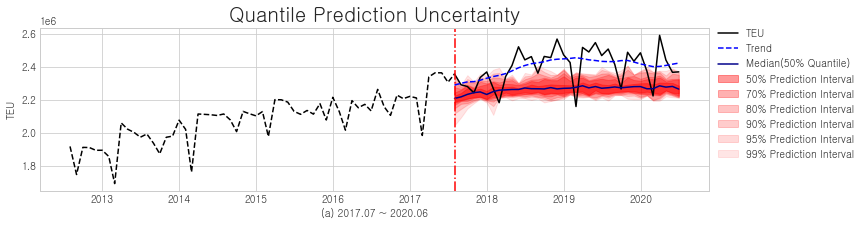

In [45]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().median())/ test_data.head(36).reset_index()['TEU'])*100) )

In [46]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.25

In [47]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.0

In [48]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 82820.91
Quantile 70% Interval Sharpness 78164.4722222222


RMSE: 157317.0635898061
MAPE: 5.592870152077186


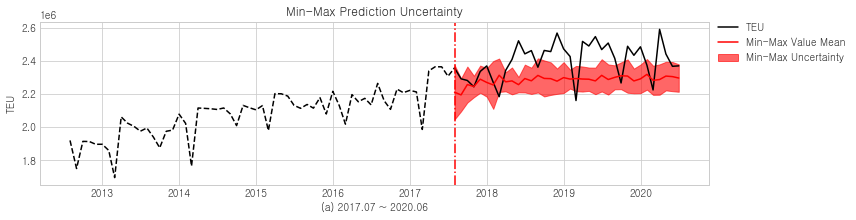

In [49]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
#plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='darkblue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='darkblue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')
plt.plot()
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(36).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [50]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.3333333333333333

In [51]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 165641.78
Quantile 95% Interval Sharpness 146162.84383680552
Min Max Interval Sharpness 176588.11


In [52]:
import CRPS.CRPS as pscore

In [53]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

114998.3936111111
48083.63652777777
24574.891111111116
7955.928055555556
63712.89833333333
101643.70666666667
13353.521111111111
59664.77750000002
58699.75111111111
122333.01083333333
246384.9127777778
153324.65583333332
167274.20388888888
68060.35027777779
164468.2627777778
157272.31277777778
270611.15194444446
164526.70944444445
129937.9825
100146.68416666666
208012.77916666667
194965.1013888889
241814.5727777778
163729.4963888889
204481.81722222222
111011.53305555556
7689.756666666665
174929.0263888889
130120.89444444444
179894.4813888889
68243.43916666666
31475.832222222227
278789.8677777778
139028.94638888887
64016.17055555556
73263.19027777779


In [54]:
a = np.array([114998.3936111111,
48083.63652777777,
24574.891111111116,
7955.928055555556,
63712.89833333333,
101643.70666666667,
13353.521111111111,
59664.77750000002,
58699.75111111111,
122333.01083333333,
246384.9127777778,
153324.65583333332,
167274.20388888888,
68060.35027777779,
164468.2627777778,
157272.31277777778,
270611.15194444446,
164526.70944444445,
129937.9825,
100146.68416666666,
208012.77916666667,
194965.1013888889,
241814.5727777778,
163729.4963888889,
204481.81722222222,
111011.53305555556,
7689.756666666665,
174929.0263888889,
130120.89444444444,
179894.4813888889,
68243.43916666666,
31475.832222222227,
278789.8677777778,
139028.94638888887,
64016.17055555556,
73263.19027777779])

In [55]:
np.mean(a)

125235.96240354938

In [56]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess,df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2271802.5

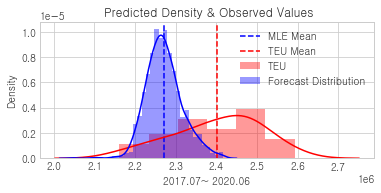

In [57]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017.07~ 2020.06')
plt.legend()

In [58]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(36).reset_index()['TEU'].mean(), scale=test_data.head(36).reset_index()['TEU'].std() ) )
LL

14379.159906755289

In [60]:
LL = -np.sum( stats.norm.logpdf(test_data.head(36).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

2053.8096088801603

In [61]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [62]:
for i in range(0,30):
    print(KL(df[i],test_data.head(36).reset_index()['TEU']))

3213026.8010427966
4711982.077816897
5054054.677933705
5340123.024045985
4381778.591480429
5399870.365175296
5404352.732067969
2213399.225849199
5073378.168532545
3657447.341015283
4644276.343776825
3729594.2796906154
5633595.425343282
4472709.858792565
5566235.219011335
3889919.0589367235
5010852.271623661
5118786.138202059
4723906.908050134
4740637.30560962
5268765.09960644
4255488.901456987
2909492.3130544494
4239120.695343612
4530956.49621551
4086200.514826021
4216324.062736935
2345812.344810534
4787612.189335903
5131255.794857453


In [63]:
a = np.array([3213026.8010427966,
4711982.077816897,
5054054.677933705,
5340123.024045985,
4381778.591480429,
5399870.365175296,
5404352.732067969,
2213399.225849199,
5073378.168532545,
3657447.341015283,
4644276.343776825,
3729594.2796906154,
5633595.425343282,
4472709.858792565,
5566235.219011335,
3889919.0589367235,
5010852.271623661,
5118786.138202059,
4723906.908050134,
4740637.30560962,
5268765.09960644,
4255488.901456987,
2909492.3130544494,
4239120.695343612,
4530956.49621551,
4086200.514826021,
4216324.062736935,
2345812.344810534,
4787612.189335903,
5131255.794857453])

In [64]:
np.mean(a)

4458365.140874692

In [42]:
df.to_csv('Attention.csv')

### 2. 2019.07 ~ 2022.06

In [43]:
X_test_2 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

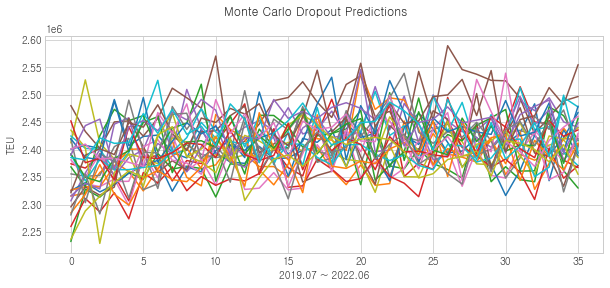

In [44]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2022.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [45]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [46]:
np.mean(df.std()/df.mean())

0.017548566684126854

In [49]:
df.to_csv('Attention.csv')

In [47]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().median())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 67810.41353335614
MAPE: 2.4120400743253936


In [48]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.tail(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2401010.5,2315588.5,2232623.0,2374350.75,2306685.5,2480398.0,2325245.0,2355808.75,2412317.0,2424979.5,2324883.75,2326449.0,2368781.5,2259853.5,2315578.25,2295683.75,2381635.75,2420529.75,2435691.5,2391449.25,2419827.5,2284646.75,2392366.5,2452629.0,2389842.75,2321488.75,2401231.75,2280884.5,2236721.0,2385666.0


In [71]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
#data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 124506.86040223039
Mean MAPE: 4.183313661369307


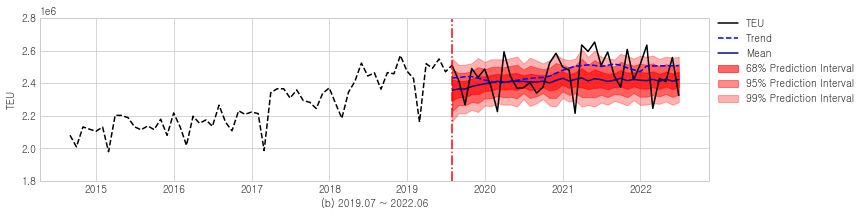

In [72]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [73]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5277777777777778


In [74]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

추세 변동에 대한 포함확률: 0.3611111111111111


Median RMSE: 125674.55001304323
Median MAPE: 4.211101482996379


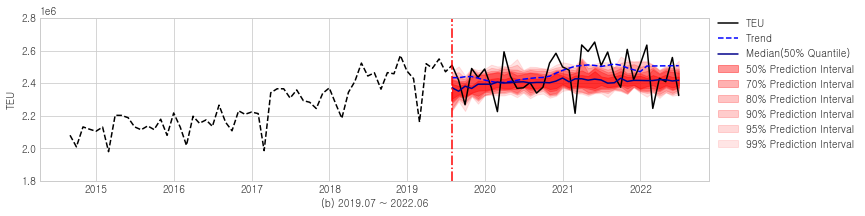

In [75]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().median())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [76]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.4722222222222222

In [77]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.3611111111111111

In [78]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 95290.07
Quantile 70% Interval Sharpness 94611.47499999999


RMSE: 106843.54804492467
MAPE: 3.506896410323683


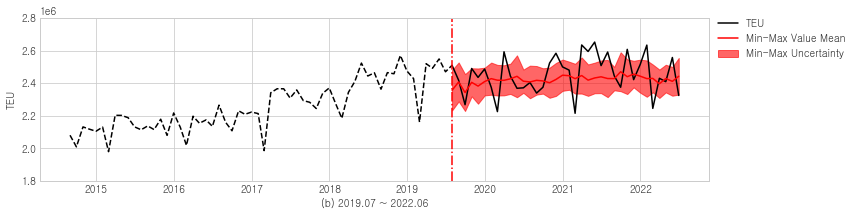

In [79]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')
plt.plot()
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(36).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [80]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.5833333333333334

In [81]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 190580.14
Quantile 95% Interval Sharpness 164343.42586805552
Min Max Interval Sharpness 194960.69


In [82]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

116411.77944444444
37787.800833333335
71505.48444444443
85180.17444444445
27012.431111111106
66196.46833333334
15219.33
160775.15944444446
160354.82444444444
22087.47083333333
25546.656111111115
23063.73027777778
11711.069444444443
44604.65416666667
21157.886111111115
95575.15916666666
137017.82055555555
51190.44722222223
48291.19861111111
184111.19249999995
169873.6822222222
153478.75722222222
192279.47583333333
62340.61555555555
154830.22194444443
18919.43194444444
31802.23222222223
165591.46666666667
9979.985555555557
72593.65166666666
191832.66583333333
151196.97055555554
12164.115277777779
13931.990555555556
118456.42694444442
72874.81666666665


In [83]:
a = np.array([116411.77944444444,
37787.800833333335,
71505.48444444443,
85180.17444444445,
27012.431111111106,
66196.46833333334,
15219.33,
160775.15944444446,
160354.82444444444,
22087.47083333333,
25546.656111111115,
23063.73027777778,
11711.069444444443,
44604.65416666667,
21157.886111111115,
95575.15916666666,
137017.82055555555,
51190.44722222223,
48291.19861111111,
184111.19249999995,
169873.6822222222,
153478.75722222222,
192279.47583333333,
62340.61555555555,
154830.22194444443,
18919.43194444444,
31802.23222222223,
165591.46666666667,
9979.985555555557,
72593.65166666666,
191832.66583333333,
151196.97055555554,
12164.115277777779,
13931.990555555556,
118456.42694444442,
72874.81666666665])

In [84]:
np.mean(a)

83248.53456018519

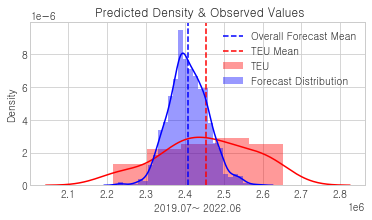

In [85]:
plt.figure(figsize=(6,3))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='blue',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.tail(36).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.tail(36).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2022.06')
plt.legend()

In [87]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [88]:
for i in range(0,30):
    print(KL(df[i],test_data.tail(36).reset_index()['TEU']))

1431062.1482508169
2603275.473779817
2773928.3523127562
1620225.0348912282
533676.099705074
1118436.9128999878
2862981.9597975486
1558941.9661832813
1831696.008704478
719284.3165181214
2118278.701977526
1760189.607600667
964500.3096748033
3463196.654966553
1299506.991504175
1790153.9642151892
1836763.401512775
1053367.6014693414
1603751.2350758729
1873640.2744171028
533730.2878115122
2540321.104432212
1218833.4615782883
1599368.6583453114
40507.01264701488
315337.9871418019
865193.2567166791
2149702.0014656484
2609694.7282650387
650727.8729788107


In [89]:
a = np.array([1431062.1482508169,
2603275.473779817,
2773928.3523127562,
1620225.0348912282,
533676.099705074,
1118436.9128999878,
2862981.9597975486,
1558941.9661832813,
1831696.008704478,
719284.3165181214,
2118278.701977526,
1760189.607600667,
964500.3096748033,
3463196.654966553,
1299506.991504175,
1790153.9642151892,
1836763.401512775,
1053367.6014693414,
1603751.2350758729,
1873640.2744171028,
533730.2878115122,
2540321.104432212,
1218833.4615782883,
1599368.6583453114,
40507.01264701488,
315337.9871418019,
865193.2567166791,
2149702.0014656484,
2609694.7282650387,
650727.8729788107])

In [90]:
np.mean(a)

1578009.112894648

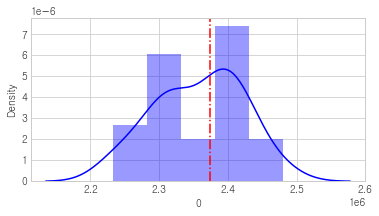

In [91]:
plt.figure(figsize=(6,3))
sns.distplot(df.transpose()[0],color='blue')
plt.axvline(test_data.tail(36)[6],linestyle='dashdot',color='red')

In [94]:
LL = -np.sum( stats.norm.logpdf(df, loc=test_data.tail(36).reset_index()['TEU'].mean(), scale=test_data.tail(36).reset_index()['TEU'].std() ) )
LL

13783.984314131256